In [319]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import biotite.structure as struc
import biotite.database.rcsb as rcsb
import biotite.structure.io.pdbx as pdbx


# =========================
# Config
# =========================
RADIUS = 1.8
MARGIN = 5.0

# If you want a slightly nicer 2D view, we can scan "roll" angles around the
# first principal axis to reduce overlaps (still CA-only).
USE_BEST_ROLL = True 
ROLL_STEPS = 240 # e.g. 240 steps = 1.5 degree resolution

# Optional gentle repel to reduce overlaps (CA-only)
USE_RELAX = True
RELAX_MIN_DIST = 0.06
RELAX_ITERS = 600

SCALE = 60.0  # just for nicer spacing

MASK_ALPHA = 0.5

# =========================
# Residue -> letter, class -> color
# =========================
one_letter_code = {
    'ARG': 'R', 'HIS': 'H', 'LYS': 'K', 'ASP': 'D', 'GLU': 'E',
    'SER': 'S', 'THR': 'T', 'ASN': 'N', 'GLN': 'Q', 'CYS': 'C',
    'GLY': 'G', 'PRO': 'P', 'ALA': 'A', 'VAL': 'V', 'ILE': 'I',
    'LEU': 'L', 'MET': 'M', 'PHE': 'F', 'TYR': 'Y', 'TRP': 'W'
}

residue_class = {
    'ARG': 'b', 'HIS': 'b', 'LYS': 'b', 'ASP': 'a', 'GLU': 'a',
    'SER': 'w', 'THR': 'w', 'ASN': 'w', 'GLN': 'w', 'CYS': 's',
    'GLY': 'g', 'PRO': 'p', 'ALA': 'n', 'VAL': 'n', 'ILE': 'n',
    'LEU': 'n', 'MET': 's', 'PHE': 'n', 'TYR': 'n', 'TRP': 'n'
}

CLASS_TO_FILL = {
    "a": "red", "b": "skyblue", "w": "green", "g": "pink",
    "n": "white", "s": "yellow", "p": "purple",
}

def aa1(res3: str) -> str:
    return one_letter_code.get(res3.upper(), "X")

def aa_class(res3: str) -> str:
    return residue_class.get(res3.upper(), "n")


In [320]:
# =========================
# Load CA only
# =========================

def load_chain_atoms(file: str, chain_id: str, model: int = 1):
    if file.endswith(".cif"):
        arr = pdbx.CIFFile.read(file)
        arr = pdbx.get_structure(arr, model=model)
    elif file.endswith(".pdb"):
        arr = pdbx.PDBFile.read(file)
        arr = pdbx.get_structure(arr, model=model)
    elif len(file) == 4 and file.isalnum():
        pdb_id = file
        pdb_id = pdb_id.upper()
        cif_path = rcsb.fetch(pdb_id, "cif")
        cif = pdbx.CIFFile.read(cif_path)
        arr = pdbx.get_structure(cif, model=model)
    else:
        raise ValueError(f"Unsupported file format: {file}")
    
    aa = arr[struc.filter_amino_acids(arr) & (arr.chain_id == chain_id)]
    return aa

def extract_ca(chain_atoms: struc.AtomArray):
    ca = chain_atoms[chain_atoms.atom_name == "CA"]
    # sort by residue id (simple; ignores insertion codes)
    order = np.argsort(ca.res_id.astype(int))
    ca = ca[order]
    print(f"Loaded {len(ca)} CA atoms from chain {chain_id} of {pdb}")
    print(f"Residue IDs: {ca.res_id[0]} to {ca.res_id[-1]}")
    print(f"Residue names: {ca.res_name[0]} to {ca.res_name[-1]}")
    print(f"Coordinates range: {ca.coord.min(axis=0)} to {ca.coord.max(axis=0)}")
    print(f"Example CA atom: res_id={ca.res_id[0]}, res_name={ca.res_name[0]}, coord={ca.coord[0]}")
    print(f"Data types: res_id={ca.res_id.dtype}, res_name={ca.res_name.dtype}, coord={ca.coord.dtype}")
    
    return ca.res_id.astype(int), ca.res_name.astype(str), ca.coord.astype(float)



In [321]:
# =========================
# Projection camera from reference
# =========================
def pca_axes(X: np.ndarray):
    Xc = X - X.mean(axis=0, keepdims=True)
    _, _, Vt = np.linalg.svd(Xc, full_matrices=False)
    return Vt[0], Vt[1], Vt[2]

def rotate_about_axis(v: np.ndarray, axis: np.ndarray, theta: float) -> np.ndarray:
    axis = axis / (np.linalg.norm(axis) + 1e-12)
    v_par = np.dot(v, axis) * axis
    v_perp = v - v_par
    return v_par + v_perp*np.cos(theta) + np.cross(axis, v_perp)*np.sin(theta)

def best_roll_theta(coords3d: np.ndarray, n_steps: int = 180, bead_radius: float = 1.2, seed: int = 0):
    rng = np.random.default_rng(seed)
    X = coords3d - coords3d.mean(axis=0, keepdims=True)

    a, b0, _ = pca_axes(X)
    a = a / (np.linalg.norm(a) + 1e-12)
    b0 = b0 / (np.linalg.norm(b0) + 1e-12)

    def score_xy(xy):
        n = len(xy)
        if n < 2:
            return 0.0
        m = min(8000, n*(n-1)//2)
        i = rng.integers(0, n, size=m)
        j = rng.integers(0, n, size=m)
        mask = i != j
        d = xy[i[mask]] - xy[j[mask]]
        dist = np.sqrt((d*d).sum(axis=1))
        overlap = np.mean(dist < (2.2 * bead_radius))
        spread = float(np.quantile(dist, 0.10))
        return -5.0*overlap + 1.0*spread

    best = (-np.inf, 0.0)
    for k in range(n_steps):
        theta = 2*np.pi*(k/n_steps)
        b = rotate_about_axis(b0, a, theta)
        b = b - np.dot(b, a) * a
        b = b / (np.linalg.norm(b) + 1e-12)
        x = X @ a
        y = X @ b
        xy = np.stack([x, y], axis=1)
        sc = score_xy(xy)
        if sc > best[0]:
            best = (sc, theta)

    return a, b0, best[1], best[0]

def project_with_camera_raw(coords3d, a, b0, theta):
    X = coords3d - coords3d.mean(axis=0, keepdims=True)

    b = rotate_about_axis(b0, a, theta)
    b = b - np.dot(b, a) * a
    b = b / (np.linalg.norm(b) + 1e-12)

    x = X @ a
    y = X @ b
    xy = np.stack([x, y], axis=1)

    return xy 


In [322]:
# =========================
# Mask + draw
# =========================
def build_mask(res_ids: np.ndarray, mask_ranges):
    if not mask_ranges:
        return np.zeros(len(res_ids), dtype=bool)
    mask = np.zeros(len(res_ids), dtype=bool)
    for start, end in mask_ranges:
        mask |= (res_ids >= start) & (res_ids <= end)
    return mask

def draw_on_axis(ax, xy, res_names, mask, title,
                 radius=RADIUS, mask_color=MASK_COLOR, mask_alpha=MASK_ALPHA):
    ax.set_aspect("equal")
    ax.set_title(title)

    for i, ((x, y), rn, is_masked) in enumerate(zip(xy, res_names, mask)):
        if is_masked:
            face = mask_color
            alpha = mask_alpha
        else:
            face = CLASS_TO_FILL.get(aa_class(rn), "white")
            alpha = 1.0

        z_circle = 2 * i
        z_text = z_circle + 1

        ax.add_patch(
            Circle((x, y), radius=radius,
                   facecolor=face, edgecolor="black", linewidth=0.8,
                   alpha=alpha, zorder=z_circle)
        )

        # No AA label on masked residues
        if not is_masked:
            ax.text(x, y, aa1(rn), ha="center", va="center",
                    fontsize=RADIUS*6, fontweight="bold", zorder=z_text)

    # N / C always visible
    xN, yN = xy[0]
    xC, yC = xy[-1]
    top = 2 * len(xy) + 10
    ax.annotate(
        "N",
        xy=(xN, yN),
        xytext=(xN, yN - 4*radius),
        ha="center",
        fontweight="bold",   # ← bold text
        arrowprops=dict(
            arrowstyle="-|>",
            lw=2.0,          # ← thicker line
            mutation_scale=15  # ← larger arrow head
        ),
        zorder=top
    )

    ax.annotate(
        "C",
        xy=(xC, yC),
        xytext=(xC, yC - 4*radius),
        ha="center",
        fontweight="bold",
        arrowprops=dict(
            arrowstyle="-|>",
            lw=2.0,
            mutation_scale=15
        ),
        zorder=top
)


    ax.axis("off")

In [323]:
def align_and_plot_front_back(entries, model=1):
    """
    entries: list of dicts like:
      {
        "pdb": "4W4O",
        "chain": "A",
        "mask_ranges": [(2,20), (45,60)]   # optional, per-entry
      }

    Align all to the first entry using biotite.structure.superimpose_homologs(),
    project with ONE shared camera (from reference), and apply ONE shared 2D scale
    across ALL proteins so density is comparable.
    Plots a grid: N proteins x 2 views (front/back).
    Masked residues: transparent grey circle + NO AA letter.
    """


    # ---------- 1) load chains + store per-entry masks ----------
    chains = []
    labels = []
    masks_per_entry = []

    for e in entries:
        pdb_id = e["pdb"]
        chain_id = e["chain"]
        chains.append(load_chain_atoms(pdb_id, chain_id, model=model))
        labels.append(f"{pdb_id.upper()}:{chain_id}")
        masks_per_entry.append(e.get("mask_ranges", None))

    # ---------- 2) align all onto reference in 3D ----------
    ref = chains[0]
    aligned = [ref]
    for mob in chains[1:]:
        mob_aligned, _, _, _ = struc.superimpose_homologs(ref, mob)
        aligned.append(mob_aligned)

    # ---------- 3) define shared camera from reference CA ----------
    ref_res_ids, ref_res_names, ref_ca = extract_ca(aligned[0])
    a, b0, theta, sc = best_roll_theta(ref_ca, n_steps=ROLL_STEPS, bead_radius=RADIUS)
    print("Reference best roll theta:", theta, "score:", sc)

    # ---------- 4) project ALL proteins (raw, unnormalized), build front/back ----------
    payloads = []
    all_xy = []

    for chain in aligned:
        res_ids, res_names, ca = extract_ca(chain)

        xy_front_raw = project_with_camera_raw(ca, a, b0, theta)
        xy_back_raw = xy_front_raw.copy()
        xy_back_raw[:, 0] *= -1.0

        payloads.append((res_ids, res_names, xy_front_raw, xy_back_raw))
        all_xy.append(xy_front_raw)
        all_xy.append(xy_back_raw)

    # ---------- 5) ONE shared 2D centering + scale across ALL proteins ----------
    all_xy = np.vstack(all_xy)
    global_center = all_xy.mean(axis=0, keepdims=True)
    all_xy_centered = all_xy - global_center

    global_span = max(np.ptp(all_xy_centered[:, 0]), np.ptp(all_xy_centered[:, 1]), 1e-9)
    # Apply same normalization then scale for plotting
    def normalize_global(xy):
        return ((xy - global_center) / global_span) * SCALE

    payloads = [
        (res_ids, res_names, normalize_global(xyF), normalize_global(xyB))
        for (res_ids, res_names, xyF, xyB) in payloads
    ]

    # ---------- 6) global limits (shared framing) ----------
    all_xy_plot = np.vstack([xyF for _, _, xyF, _ in payloads] + [xyB for _, _, _, xyB in payloads])
    minx, miny = all_xy_plot.min(axis=0) - (MARGIN + 2 * RADIUS)
    maxx, maxy = all_xy_plot.max(axis=0) + (MARGIN + 2 * RADIUS)

    # ---------- 7) plot grid: N proteins x 2 views ----------
    n = len(entries)
    fig, axes = plt.subplots(n, 2, figsize=(16, 6 * n))
    if n == 1:
        axes = np.array([axes])

    for i, (label, (res_ids, res_names, xy_front, xy_back), mask_ranges) in enumerate(
        zip(labels, payloads, masks_per_entry)
    ):
        mask = build_mask(res_ids, mask_ranges)

        axL = axes[i, 0]
        axR = axes[i, 1]

        draw_on_axis(
            axL, xy_front, res_names, mask,
            title=f"{label}: Front",
            radius=RADIUS, mask_color=MASK_COLOR, mask_alpha=MASK_ALPHA
        )
        draw_on_axis(
            axR, xy_back, res_names, mask,
            title=f"{label}: Back",
            radius=RADIUS, mask_color=MASK_COLOR, mask_alpha=MASK_ALPHA
        )

        axL.set_xlim(minx, maxx); axL.set_ylim(miny, maxy)
        axR.set_xlim(minx, maxx); axR.set_ylim(miny, maxy)

    plt.tight_layout()
    plt.show()
    return fig, axes


Loaded 172 CA atoms from chain A of 4W4O
Residue IDs: 1 to 172
Residue names: ALA to PRO
Coordinates range: [-25.662 -26.282  -3.16 ] to [ 6.514 28.867 40.698]
Example CA atom: res_id=1, res_name=ALA, coord=[-13.235  28.867  13.561]
Data types: res_id=int64, res_name=<U5, coord=float32
Reference best roll theta: 0.20943951023931953 score: 7.501564880584359
Loaded 172 CA atoms from chain A of 4W4O
Residue IDs: 1 to 172
Residue names: ALA to PRO
Coordinates range: [-25.662 -26.282  -3.16 ] to [ 6.514 28.867 40.698]
Example CA atom: res_id=1, res_name=ALA, coord=[-13.235  28.867  13.561]
Data types: res_id=int64, res_name=<U5, coord=float32
Loaded 171 CA atoms from chain A of 4W4O
Residue IDs: 2 to 172
Residue names: LEU to GLY
Coordinates range: [-27.787931 -26.110476  -1.980053] to [ 6.571853 26.976171 41.017624]
Example CA atom: res_id=2, res_name=LEU, coord=[-16.264141  26.976171  14.120373]
Data types: res_id=int64, res_name=<U5, coord=float32


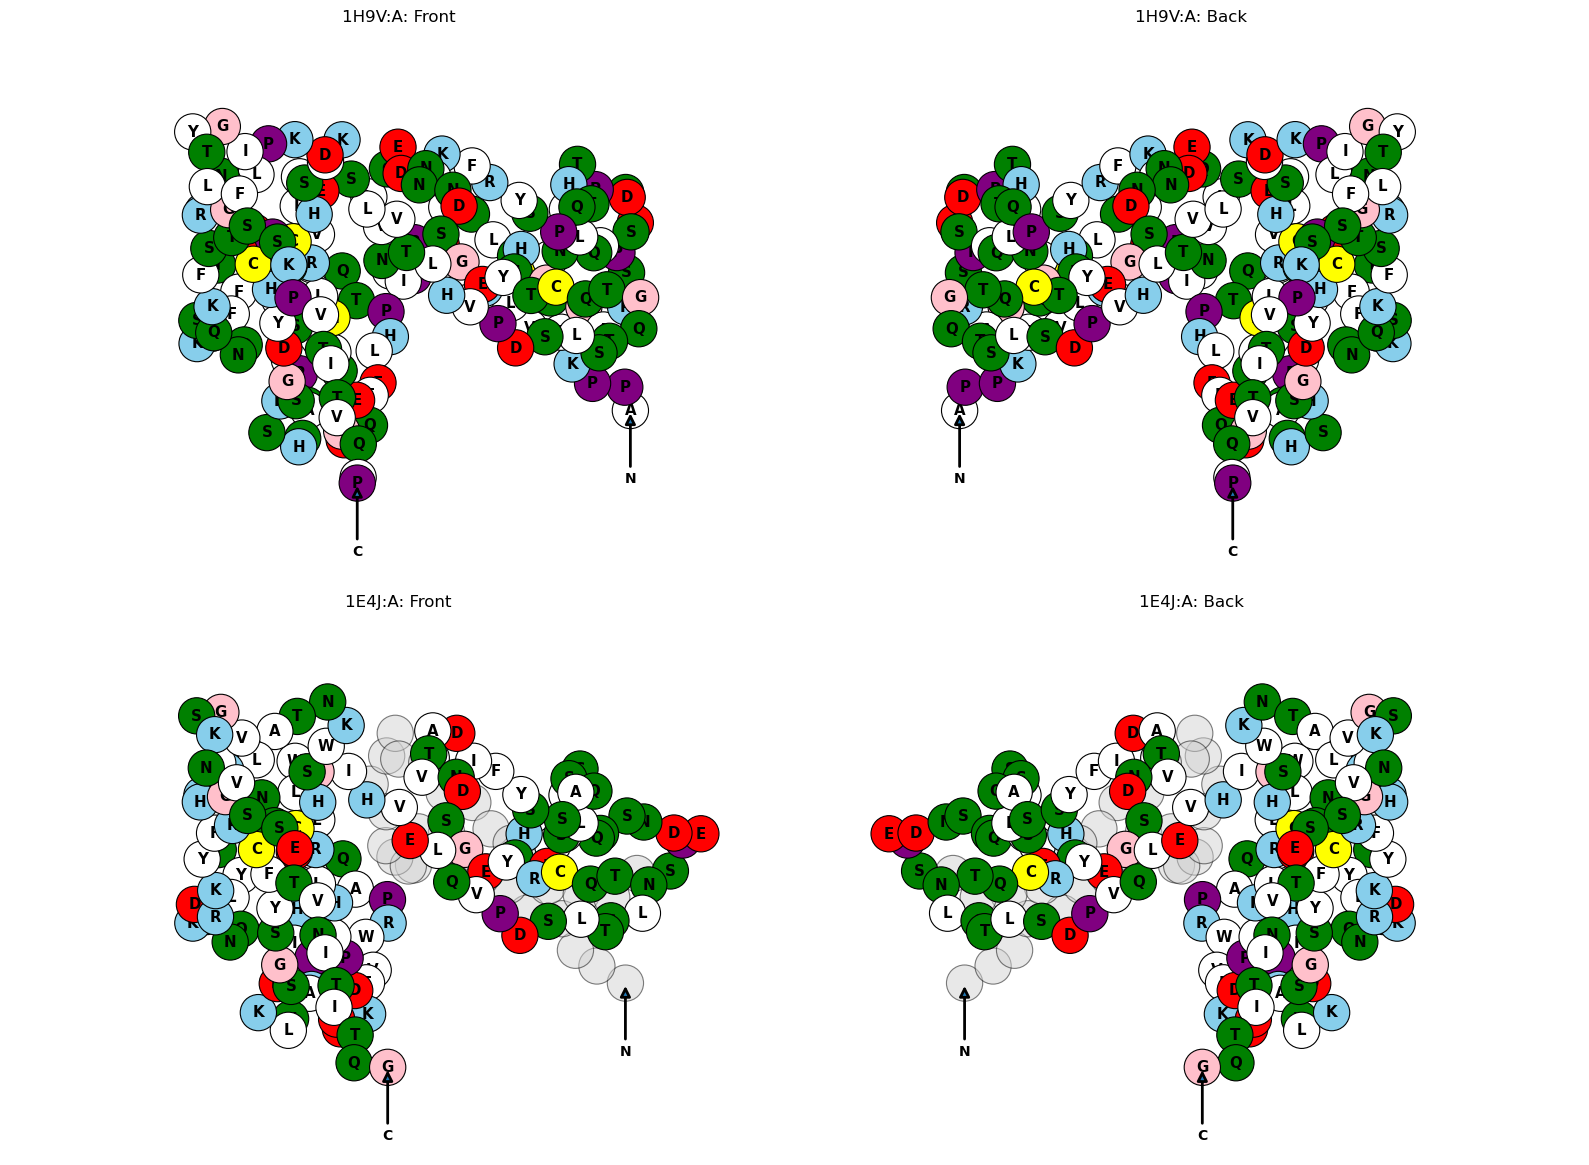

(<Figure size 1600x1200 with 4 Axes>,
 array([[<Axes: title={'center': '1H9V:A: Front'}>,
         <Axes: title={'center': '1H9V:A: Back'}>],
        [<Axes: title={'center': '1E4J:A: Front'}>,
         <Axes: title={'center': '1E4J:A: Back'}>]], dtype=object))

In [324]:
entries = [
    {"pdb": "1H9V", "chain": "A", "mask_ranges": [(232, 300), (400, 450)]},
    {"pdb": "1E4J", "chain": "A", "mask_ranges": [(0, 30)]},
]

align_and_plot_front_back(entries, model=1)